<a href="https://colab.research.google.com/github/ravi-maithrey/skin-cancer-detection/blob/main/skin_cancer_efficientnetb0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 99% 321M/325M [00:10<00:00, 44.0MB/s]
100% 325M/325M [00:10<00:00, 33.2MB/s]


In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!unzip  ./skin-cancer-malignant-vs-benign.zip 

In [ ]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

%matplotlib inline

In [ ]:
!pip install efficientnet
import efficientnet.tfkeras as efn 

     |████████████████████████████████| 51kB 4.8MB/s 


In [ ]:
SEED = 42
np.random.seed(SEED)

## Image Segmentation with KMeans

In [ ]:
from skimage.filters import rank, threshold_otsu
from skimage.color import rgb2grey
from sklearn.cluster import KMeans
from skimage.morphology import closing, square, disk

In [ ]:
def plot_any(arr, title = ''):
    plt.figure(figsize = (15, 25))
    for i in range(len(arr)):
        plt.subplot(1,len(arr),i + 1)
        plt.title(title)
        plt.imshow(arr[i]);

        
def d2Kmeans(img, k):
    return KMeans(n_jobs=-1, 
                  random_state=1, 
                  n_clusters = k, 
                  init='k-means++'
    ).fit(img.reshape((-1,1))).labels_.reshape(img.shape)


def merge_segmented_mask_ROI(uri_img, img_kluster):
    new_img = uri_img.copy()
    for ch in range(3):
        new_img[:,:, ch] *= img_kluster
    return new_img


def mean_filter(image, radius):
    return rank.mean_percentile(image, selem = disk(radius))


def binary(image):
    return image > threshold_otsu(image)


def select_cluster_index(clusters):
    minx = clusters[0].mean()
    index = 0
    for i in clusters:
        if i.mean() < minx:
            minx = i.mean()
            index += 1
    return index


def segment_image(img, k = 2):
    # Cluster the image
    result_gray = d2Kmeans(rgb2grey(img), k)
    
    # Select the correct cluster
    clusters_gray = [result_gray == i for i in range(k)]
    selected_index = select_cluster_index(clusters_gray)
    results_gray = clusters_gray[selected_index]
    
    # Apply smoothing of the boundaries
    image_mean_filter = mean_filter(results_gray, 20)
    test_binary = binary(image_mean_filter)
    
    # Create segmented picture with black background
    new_img = merge_segmented_mask_ROI(img, test_binary)
    
    return new_img

# Loading & Preprocessing

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            img = segment_image(img)
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/input/data/train/benign',224))
malign_train = np.array(Dataset_loader('/content/input/data/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/input/data/test/benign',224))
malign_test = np.array(Dataset_loader('/content/input/data/test/malignant',224))

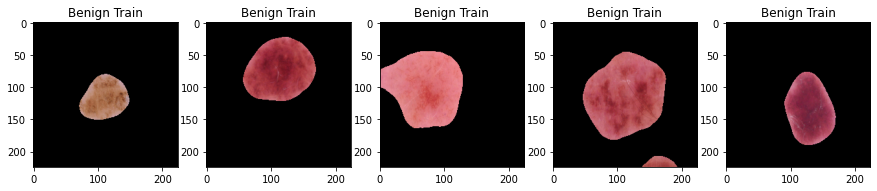

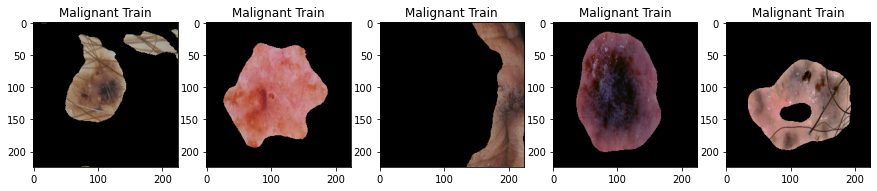

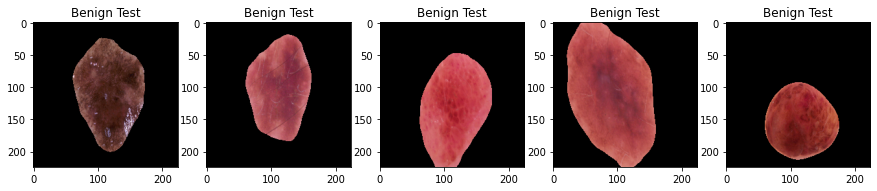

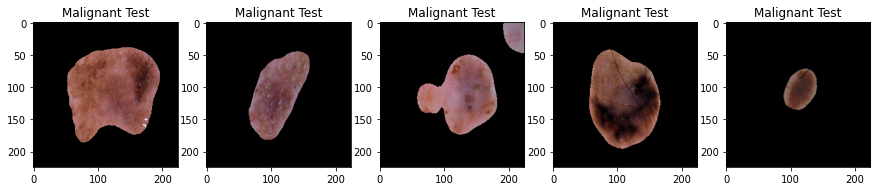

In [ ]:
plot_any(benign_train[:5], title = "Benign Train")
plot_any(malign_train[:5], title = "Malignant Train")
plot_any(benign_test[:5], title = "Benign Test")
plot_any(malign_test[:5], title = "Malignant Test")

# Create Label

In [ ]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes= 2)
Y_test = tf.keras.utils.to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split
Now we can split it into a training and validation set.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=SEED
)

# Display Some Images

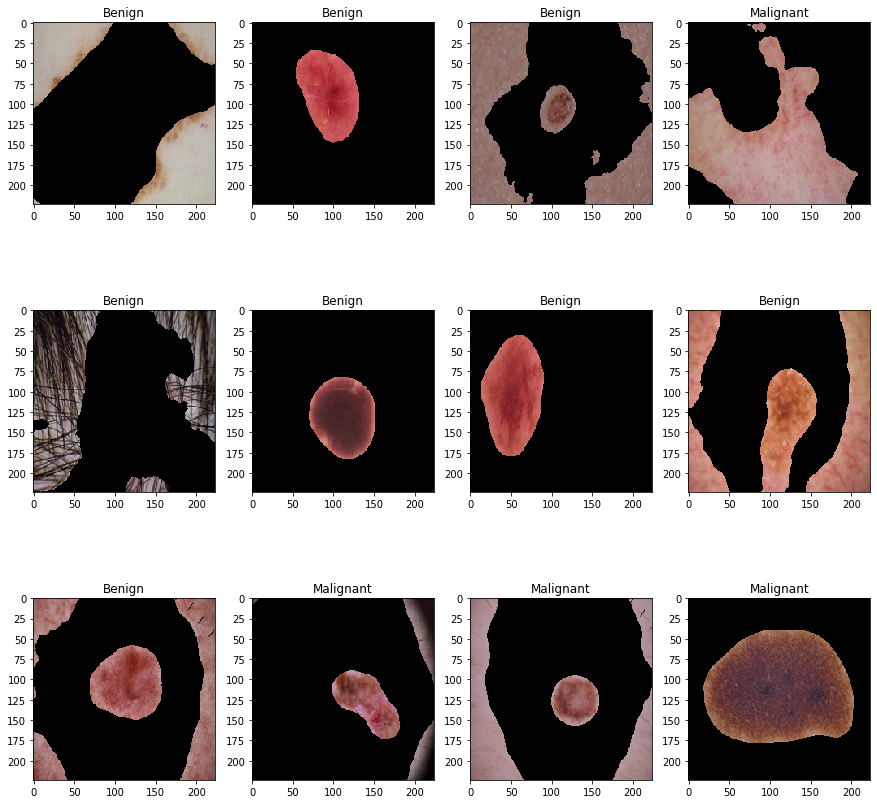

In [ ]:

# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
BATCH_SIZE = 32

# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=(0.75,1),
                                   brightness_range=(0.75,1.25)
                                  )

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
val_generator = train_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, shuffle= False)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE, shuffle= False)

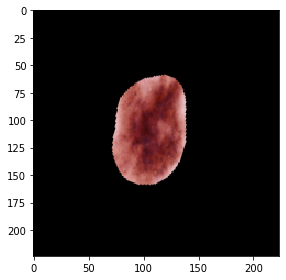

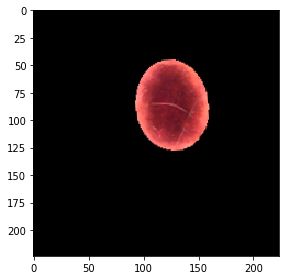

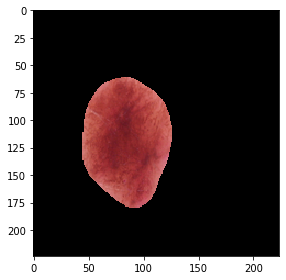

In [ ]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x1, y1 = train_generator[0]
x2, y2 = val_generator[0]
x3, y3 = test_generator[0]

imshow(x1[0])
imshow(x2[0])
imshow(x3[0])

# Model:

In [ ]:
def build_model(backbone, lr=1e-4):
    model = tf.keras.Sequential()
    model.add(backbone)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    
    return model

In [ ]:
efficientnetb3 = efn.EfficientNetB0(
        weights='imagenet',
        input_shape=(224,224,3),
        include_top=False
                   )

model = build_model(efficientnetb3)
model.summary()


16809984/16804768 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 4,057,246
Trainable params: 4,012,670
Non-trainable params: 44,576
_________________________________________________________________


In [ ]:
model.compile(
        loss='categorical_crossentropy',
        optimizer = keras.optimizers.Adam(learning_rate=0.001, 
                                          beta_1=0.9, 
                                          beta_2=0.999, 
                                          epsilon=1e-07, 
                                          amsgrad=False),
              metrics=['accuracy'])




In [ ]:
# Learning Rate Reducer
learn_control = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                  patience=5,
                                  verbose=1,
                                  factor=0.2, 
                                  min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

# Training & Evaluation

In [ ]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[learn_control, checkpoint]
)

Epoch 1/30
66/66 [==============================] - 49s 741ms/step - loss: 0.4197 - accuracy: 0.8042 - val_loss: 0.6178 - val_accuracy: 0.6231

Epoch 00001: val_loss improved from inf to 0.61779, saving model to weights.best.hdf5
Epoch 2/30
66/66 [==============================] - 49s 742ms/step - loss: 0.3958 - accuracy: 0.8156 - val_loss: 0.7628 - val_accuracy: 0.6004

Epoch 00002: val_loss did not improve from 0.61779
Epoch 3/30
66/66 [==============================] - 50s 749ms/step - loss: 0.3791 - accuracy: 0.8212 - val_loss: 0.5666 - val_accuracy: 0.7841

Epoch 00003: val_loss improved from 0.61779 to 0.56656, saving model to weights.best.hdf5
Epoch 4/30
66/66 [==============================] - 50s 748ms/step - loss: 0.3444 - accuracy: 0.8388 - val_loss: 0.3926 - val_accuracy: 0.8068

Epoch 00004: val_loss improved from 0.56656 to 0.39256, saving model to weights.best.hdf5
Epoch 5/30
66/66 [==============================] - 50s 751ms/step - loss: 0.3592 - accuracy: 0.8388 - val_

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

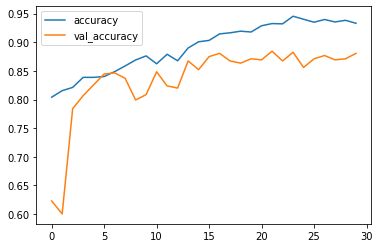

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

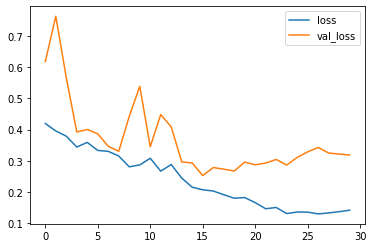

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [ ]:
model.load_weights("weights.best.hdf5")

In [ ]:
val_generator.reset()
Y_val_pred = model.predict_generator(val_generator, steps=np.ceil(x_val.shape[0]/BATCH_SIZE))
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0.8787878787878788

In [ ]:
test_generator.reset()
Y_pred = model.predict_generator(test_generator, steps=np.ceil(X_test.shape[0]/BATCH_SIZE))
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0.8424242424242424

# Test Time Augmentation


In [ ]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    test_generator = train_datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE, shuffle= False)
    preds = model.predict_generator(test_generator, steps=np.ceil(X_test.shape[0]/BATCH_SIZE))
    predictions.append(preds)

    del test_generator
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
100%|██████████| 10/10 [01:35<00:00,  9.53s/it]


In [ ]:
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

0.8424242424242424

In [ ]:
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

0.8681818181818182

Confusion matrix, without normalization
[[317  43]
 [ 61 239]]


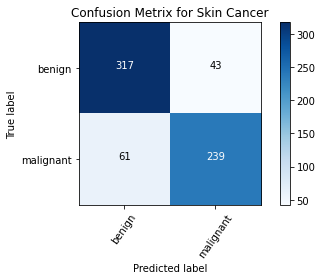

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[309  51]
 [ 36 264]]


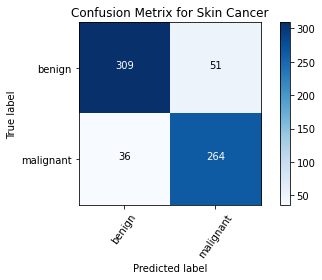

In [ ]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1)))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       360
           1       0.84      0.88      0.86       300

    accuracy                           0.87       660
   macro avg       0.87      0.87      0.87       660
weighted avg       0.87      0.87      0.87       660



### ROC and AUC

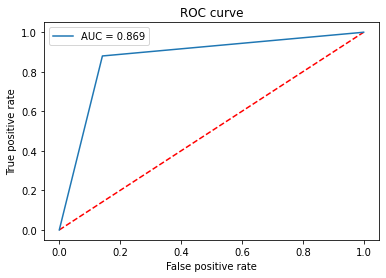

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
plt.close()

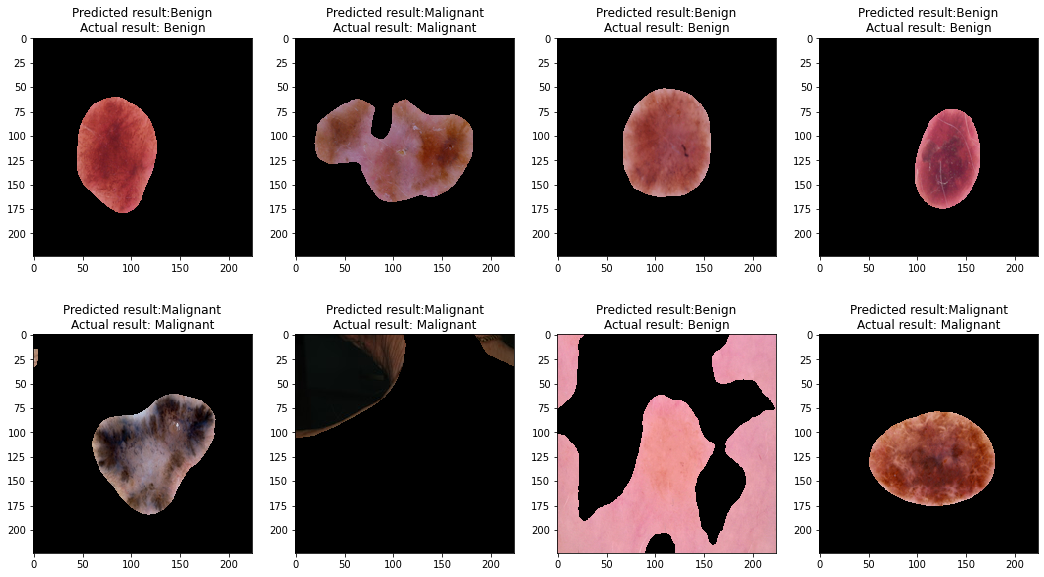

In [ ]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

In [ ]:
# save model
# serialize model to JSON
model_json = model.to_json()

with open("efficientnetb0.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("efficientnet.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/
Mounted at /content/gdrive


In [ ]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [ ]:
!cp -r /content/weights.best.hdf5 /mydrive
!cp -r /content/efficientnet.h5 /mydrive   
!cp -r /content/efficientnetb0.json /mydrive   